# Exercise 4

In [1]:
import numpy as np
import cv2

from PIL import Image
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
def show_image(image, title='', axes='off', figsize=(10,10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image, cmap='gray', interpolation='nearest')
    ax.axis(axes)
    ax.set_title(title)
    return fig, ax

def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)

In [3]:
img1 = load_image('Images/001.jpg')

(<matplotlib.figure.Figure at 0x7f7b8229fa90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7b822ad358>)

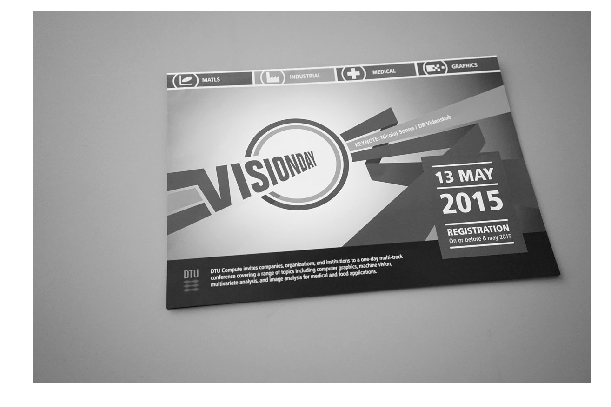

In [4]:
show_image(img1)

### Manually select corners

In [5]:
# Hard-code corner points 
img1_corner_points = np.array([
    (290, 134),  # top-left corner
    (993, 96),   # top-right corner
    (1132, 565), # bottom-right corner
    (287, 641)   # bottm-left corner
])

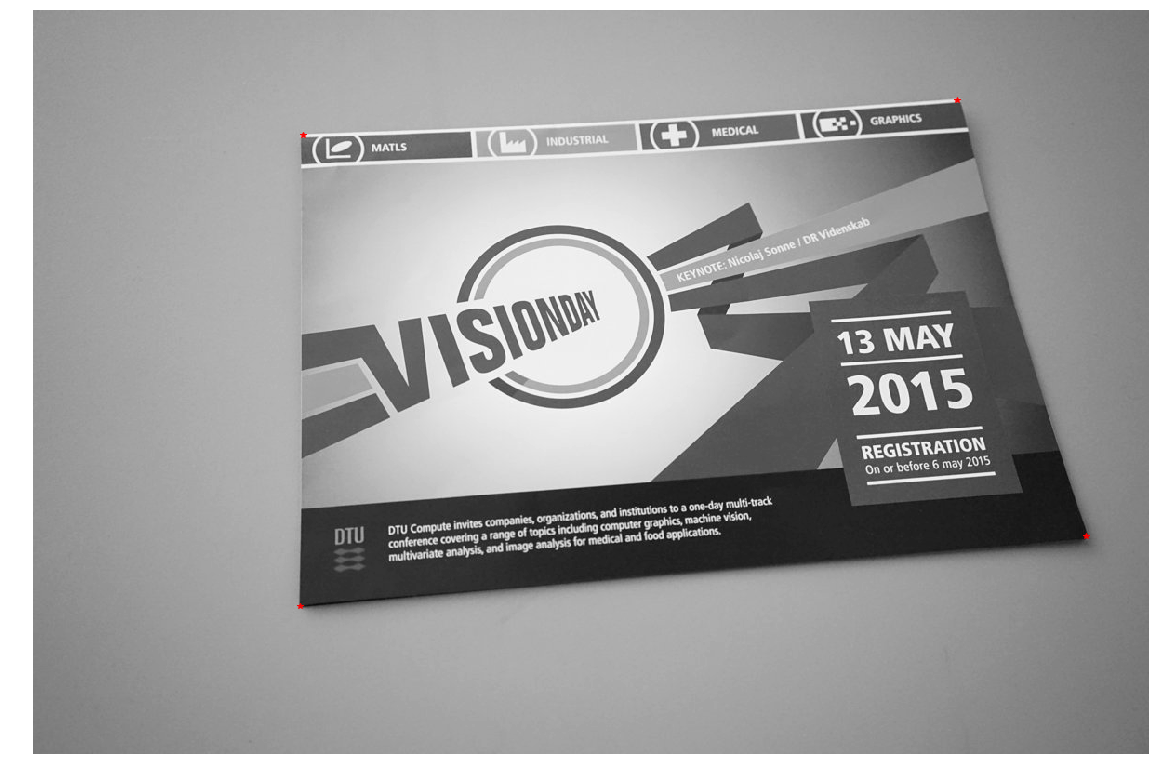

In [6]:
# Plot corner pointers
fig, ax = show_image(img1, figsize=(20, 15))
corners_x = img1_corner_points[:,:1].flatten()
corners_y = img1_corner_points[:,1:].flatten()
ax.plot(corners_x, corners_y, 'r*')

### Extract SIFT Features

(<matplotlib.figure.Figure at 0x7f7bb88b79b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7bb8957470>)

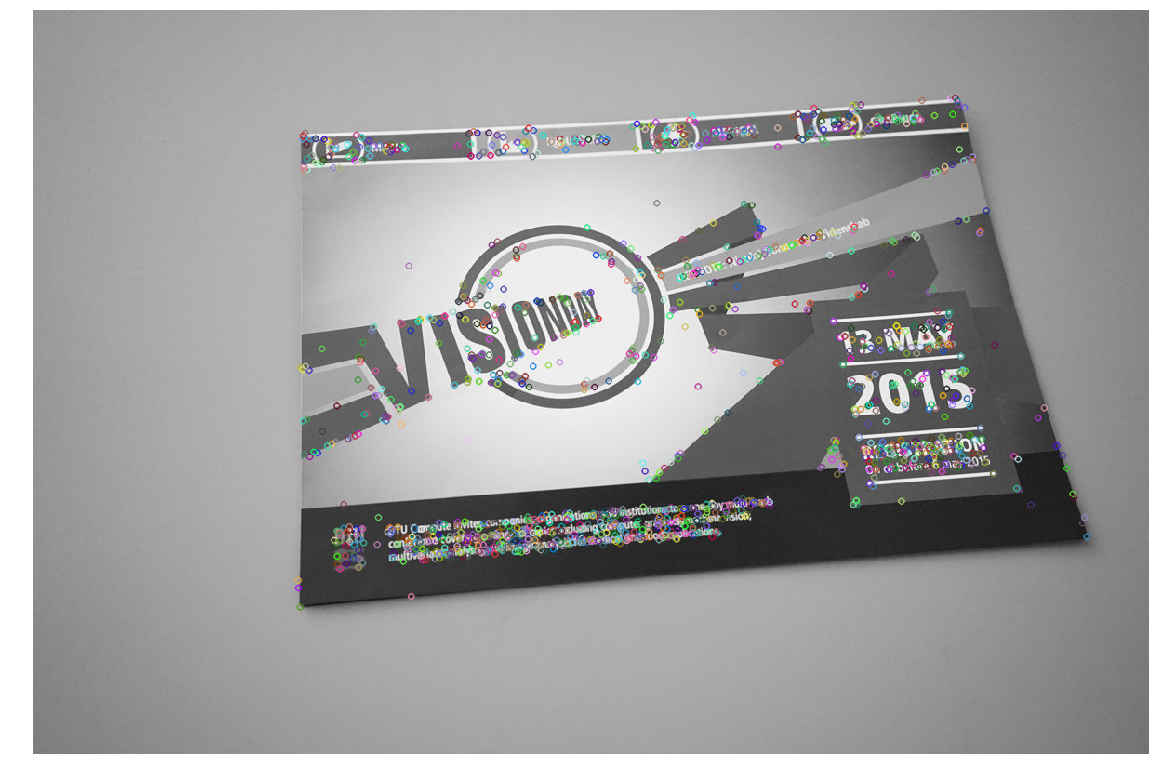

In [7]:
sift = cv2.xfeatures2d.SIFT_create()

kp1, desc1 = sift.detectAndCompute(img1, None)
img = cv2.drawKeypoints(img1, kp1, outImage=None)
show_image(img, figsize=(20, 15))

In [8]:
img2 = load_image('Images/002.jpg')

In [9]:
kp2, desc2 = sift.detectAndCompute(img2, None)

### Compute matches

We use the Brute-Force Matcher (BFMatcher) to match the SIFT features. BFMatcher is going to try all the possibilities and will find the best matches. The alternative, FLANN (Fast Library for Approximate Nearest Neighbors) tries to match based on an approximate nearest neighbors. It is much faster but will not necessarily find the best possible matches. Playing FLANN's parameters can increase the precision but the cost is a slower algorithm.

Note: [Norm L2](http://mathworld.wolfram.com/L2-Norm.html) is the Euclidean distance (square root of sum of squares).

In [10]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc1, desc2, k=2)

print('Number of matches {}'.format(len(matches)))

# Apply ratio test
good_matches = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good_matches.append(m)
matches = good_matches

Number of matches 1576


### Draw matches

In [11]:
img1_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ])
img2_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ])

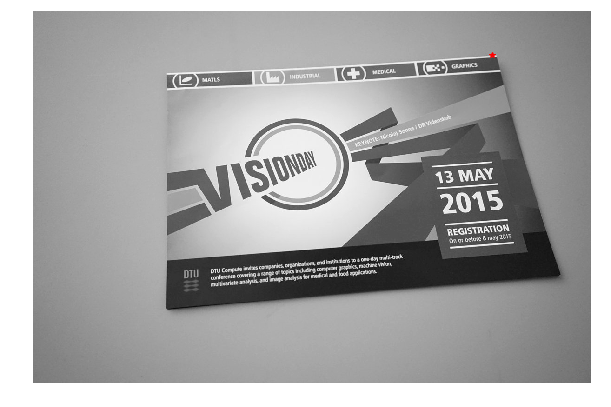

In [12]:
fig, ax = show_image(img1)

point = img1_pts[0]
ax.plot(point[0], point[1], 'r*')

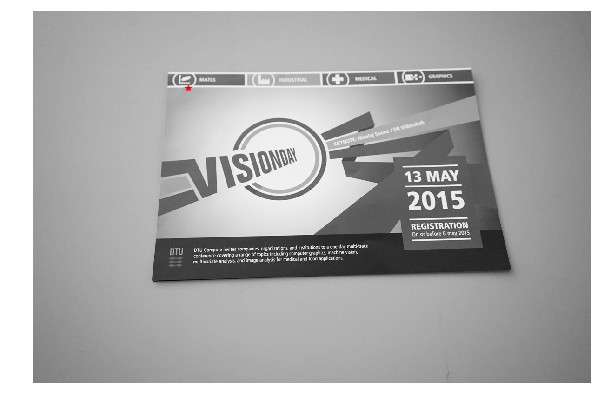

In [13]:
fig, ax = show_image(img2)

point = img2_pts[0]
ax.plot(point[0], point[1], 'r*')

### Draw top matches

(<matplotlib.figure.Figure at 0x7f7bb8963908>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7bb88b1048>)

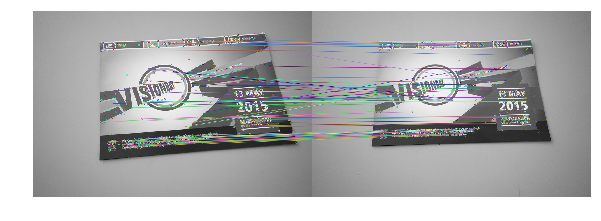

In [14]:
# draw the top N matches
N_MATCHES = 100
sorted_matches = sorted(matches, key = lambda x: x.distance)[:N_MATCHES]

match_img = cv2.drawMatches(
    img1, kp1,
    img2, kp2,
    sorted_matches, None, flags=0)
cv2.imwrite('match_img.png',match_img)
show_image(match_img)

Note that are many points that are mismatched.

### Compute Homography

From the [OpenCV document](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html):

> We have seen that there can be some possible errors while matching which may affect the result. To solve this problem, algorithm uses RANSAC or LEAST_MEDIAN (which can be decided by the flags). So good matches which provide correct estimation are called inliers and remaining are called outliers. `cv2.findHomography()` returns a mask which specifies the inlier and outlier points.

In [15]:
H, mask = cv2.findHomography(img1_pts, img2_pts, cv2.RANSAC, 5.0)
H

array([[  8.87823703e-01,  -5.86811423e-02,   4.20530705e+01],
       [  3.26039404e-02,   9.00416962e-01,   1.26658924e+00],
       [ -2.59578268e-05,   2.88094336e-05,   1.00000000e+00]])

In [16]:
# Convert image 1 points into homogeneous coordinates
ones = np.ones((4,1), dtype=np.int32)
img1_homogen_corner_points = np.append(img1_corner_points, ones, axis=1)
img1_homogen_corner_points

array([[ 290,  134,    1],
       [ 993,   96,    1],
       [1132,  565,    1],
       [ 287,  641,    1]])

In [17]:
# Compute corresponding corner point in image 2 using the estimated homography
img2_homogen_corner_points = np.matmul(H, img1_homogen_corner_points.transpose())
img2_homogen_corner_points

array([[  2.91658671e+02,   9.18028618e+02,   1.01391466e+03,
          2.59243861e+02],
       [  1.31377605e+02,   1.20082330e+02,   5.46909834e+02,
          5.87791193e+02],
       [  9.96332694e-01,   9.76989584e-01,   9.86893070e-01,
          1.01101695e+00]])

In [18]:
# Convert back from homogenous coordinate
img2_corner_points = img2_homogen_corner_points[:-1] / img2_homogen_corner_points[-1]
img2_corner_points

array([[  292.7322097 ,   939.65036365,  1027.38046017,   256.41890651],
       [  131.86118019,   122.91055351,   554.1733448 ,   581.38609118]])

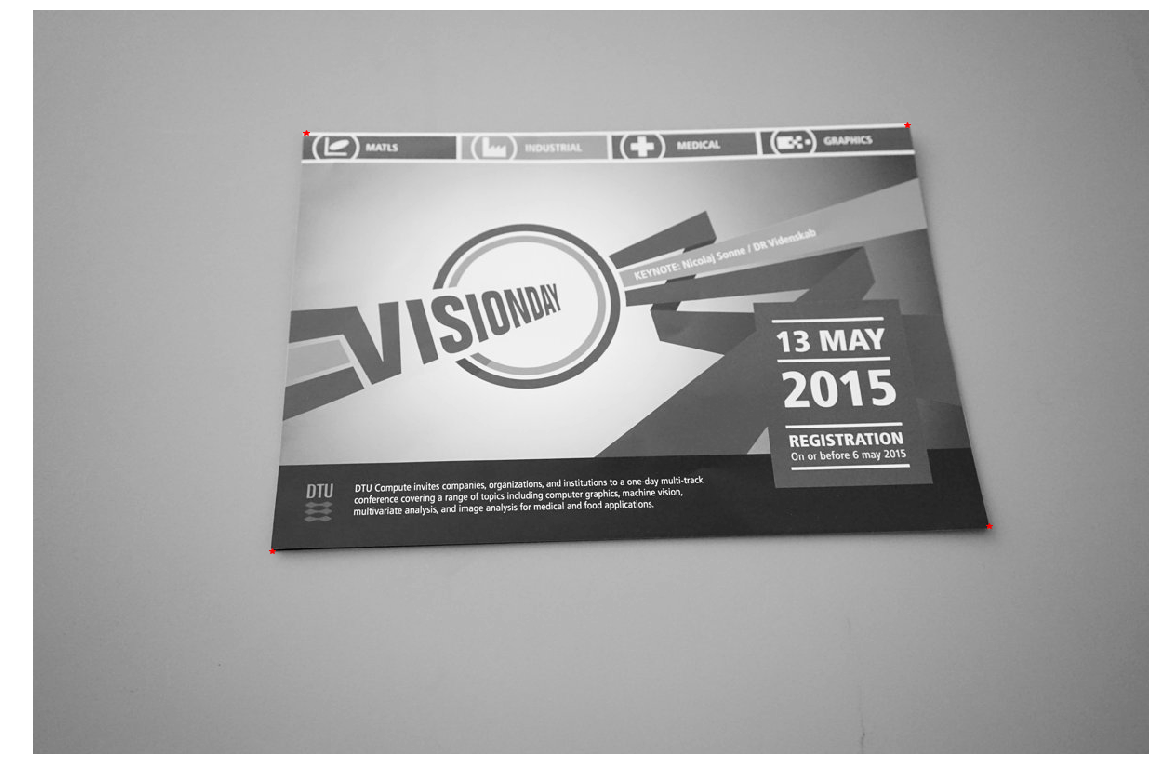

In [19]:
# Plot the points on the image
fig, ax = show_image(img2, figsize=(20, 15))
corners_x = img2_corner_points[0]
corners_y = img2_corner_points[1]
ax.plot(corners_x, corners_y, 'r*')

### Combining it all together

In [20]:
src_img = load_image('Images/001.jpg')
src_img_corner_points = np.array([
    (290, 134),  # top-left corner
    (993, 96),   # top-right corner
    (1132, 565), # bottom-right corner
    (287, 641)   # bottm-left corner
])
sift = cv2.xfeatures2d.SIFT_create()
src_kp, src_desc = sift.detectAndCompute(src_img, None)


def find_matches(src_img_descriptors, dst_img_descriptors):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(src_img_descriptors, dst_img_descriptors, k=2)

    # Apply ratio test
    good_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good_matches.append(m)
    return good_matches


def show_corner_points(dst_path='Images/003.jpg'):

    dst_img = load_image(dst_path)    

    # Compute SIFT descriptors
    sift = cv2.xfeatures2d.SIFT_create()
    dst_kp, dst_desc = sift.detectAndCompute(dst_img, None)
    
    # Find matches
    matches = find_matches(src_desc, dst_desc)
    
    # Extract matched points
    src_img_pts = np.float32([ src_kp[m.queryIdx].pt for m in matches ])
    dst_img_pts = np.float32([ dst_kp[m.trainIdx].pt for m in matches ])
    
    # Estimate homography based on the matching points
    H, mask = cv2.findHomography(src_img_pts, dst_img_pts, cv2.RANSAC, 5.0)
    
    # Convert source image 1 points into homogeneous coordinates
    ones = np.ones((4,1), dtype=np.int32)
    src_img_corner_points_homogen = np.append(src_img_corner_points, ones, axis=1)
    
    # Compute corresponding corner point in image 2 using the estimated homography
    dst_img_corner_points_homogen = np.matmul(H, src_img_corner_points_homogen.transpose())
    
    # Convert back from homogenous coordinate so we can plot the points
    dst_img_corner_points = dst_img_corner_points_homogen[:-1] / dst_img_corner_points_homogen[-1]

    # Plot the points on the image
    fig, ax = show_image(dst_img, figsize=(10, 8))
    corners_x = dst_img_corner_points[0]
    corners_y = dst_img_corner_points[1]
    ax.plot(corners_x, corners_y, 'r*')

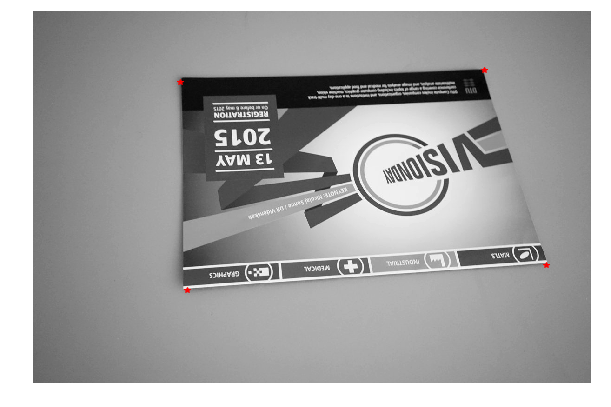

In [21]:
show_corner_points('Images/015.jpg')

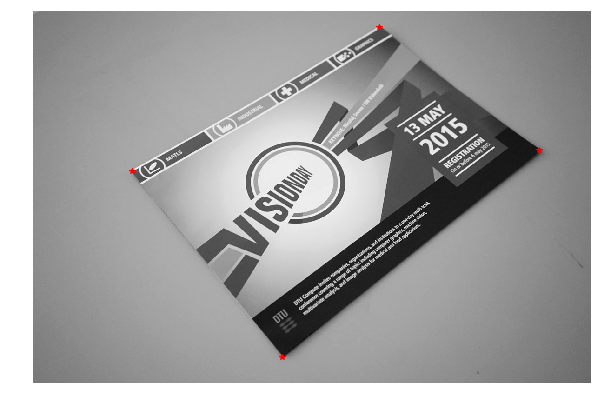

In [22]:
show_corner_points('Images/027.jpg')

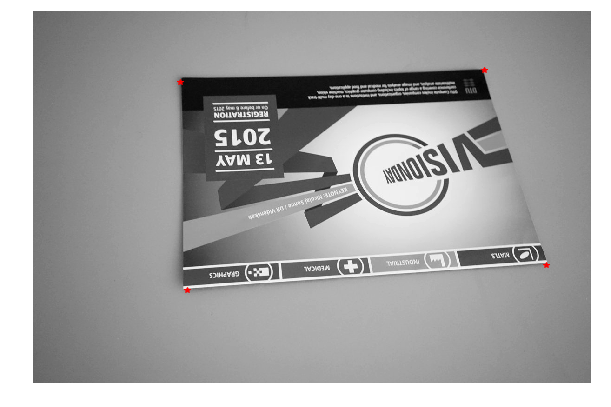

In [23]:
show_corner_points('Images/015.jpg')

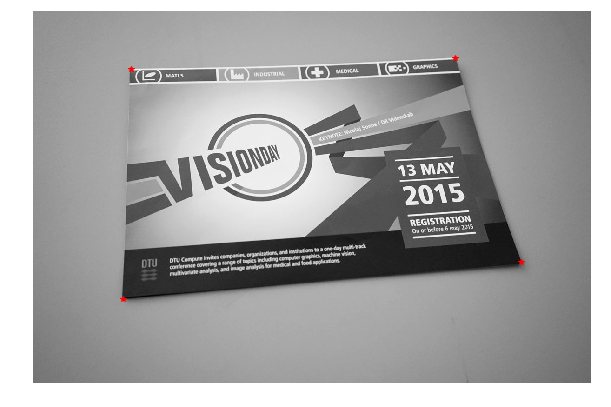

In [24]:
show_corner_points('Images/031.jpg')